##### 2D U-Net Shuffled

Here we are using a 2D u-net but rotating around which subject we use as test set
We are doing this since we have a small dataset and want to see if our average results change (IOU, dice)

Can change the size of train test split with NUMBER_TEST_SUBJECTS





In [16]:
# Import required libraries
from monai.utils import first, set_determinism
from monai.transforms import (
AsDiscrete,
AsDiscreted,
EnsureChannelFirstd,
Compose,
CropForegroundd,
LoadImaged,
Orientationd,
Spacingd,
Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
from monai.transforms import Randomizable, Rotate
import scipy.ndimage

import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import UNet
from monai.losses import DiceLoss

import torch
import numpy as np
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob



import SimpleITK as sitk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [17]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")


root dir is: /scratch/6981653.1.ece/tmp013z2tcd


In [18]:
# Define paths to the folders containing images and masks
data_folder = "/projectnb/ec500kb/projects/Project_3/Maolin/Data/"
masks_folder = "/projectnb/ec500kb/projects/Project_3/Maolin/Data/"  # Same as the image folder

# Create empty lists to store image and mask data
image_dataset = []
left_mask_dataset = []
right_mask_dataset = []

TwoD_image_dataset = []
TwoD_mask_dataset = []

# Iterate through image files and import them
for images_folder in os.listdir(data_folder):
    if os.path.isdir(os.path.join(data_folder, images_folder)):
        print(images_folder)
        for filename in os.listdir(os.path.join(data_folder, images_folder)):
            if filename.endswith('.nrrd'):
                # Construct full path to the image file
                raw_img_path = os.path.join(data_folder, images_folder, filename)

                # Read in image
                raw_img_sitk = sitk.ReadImage(raw_img_path, sitk.sitkFloat32)
                # print(raw_img_sitk)
                # Convert the array
                raw_img_sitk_arr = sitk.GetArrayFromImage(raw_img_sitk)
                # print(raw_img_sitk_arr.shape[0])
                
                for s in range(raw_img_sitk_arr.shape[0]):
                    TwoD_image_dataset.append(raw_img_sitk_arr[s,:,:])
                    for side in ["left", "right"]:  # It is done this way so that I import 5 copies of each mask. since the same mask is used for each image volume
                        mask_filename = f"svr_{side}KidneyMask2.nii.gz"
                        mask_path = os.path.join(masks_folder, images_folder, mask_filename)

                        # Read in mask
                        raw_mask_sitk = sitk.ReadImage(mask_path, sitk.sitkFloat32)

                        # Convert the array
                        mask_arr = sitk.GetArrayFromImage(raw_mask_sitk)

                        if side == "left":
                            left_mask_dataset.append(mask_arr[0])
                        elif side == "right":
                            right_mask_dataset.append(mask_arr[0])
              
            # Add image data to list
                image_dataset.append(raw_img_sitk_arr)

                # Iterate through each mask file
                

# Convert lists to numpy arrays
image_dataset = np.array(image_dataset)
left_mask_dataset = np.array(left_mask_dataset)
right_mask_dataset = np.array(right_mask_dataset)

# Combine the left and right kidney masks into one mask
combined_masks = []

for i in range(len(left_mask_dataset)):
    combined_masks.append(left_mask_dataset[i] + right_mask_dataset[i])
    
combined_masks = np.array(combined_masks);




TwoD_image_dataset = np.array(TwoD_image_dataset)
TwoD_mask_dataset = np.array(combined_masks)

# Print the shapes to verify
# print("Image dataset shape:", image_dataset.shape)  # samples, slices, slice_x, slice_y
# print("Left Mask dataset shape:", left_mask_dataset.shape)
# print("Right Mask dataset shape:", right_mask_dataset.shape)
print("2d image dataset shape:", TwoD_image_dataset.shape)
print("2d mask dataset shape:", TwoD_mask_dataset.shape)



case7
case3
case4
case5
case8
case1
case2
case6
2d image dataset shape: (720, 128, 128)
2d mask dataset shape: (720, 128, 128)


In [19]:

mean_dice_scores = []
test_losses = []
mean_iou_test = []
mean_iou_train = []
NUMBER_OF_TEST_SUBJECTS = 2


import torch
import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import UNet
from monai.losses import DiceLoss

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define the UNet model
class MyUNet(nn.Module):
    def __init__(self):
        super(MyUNet, self).__init__()
        self.unet = UNet(
            spatial_dims=2,  # Set spatial dimensions to 2 for 2D data
            in_channels=1,  # Input volume with 18 channels
            out_channels=1,  # Single channel output mask
            channels=(16, 32, 64, 128, 256), #, 256 # Depth of 5 - Look at why 256 is here
            strides=(2, 2, 2,2),
            num_res_units=2,  # Number of residual units
            dropout=0.1  # Optional dropout
        )

    def forward(self, x):
        return self.unet(x)

# Initialize the model and move it to the GPU
model = MyUNet().to(device)

# Define Dice Loss
criterion = DiceLoss(sigmoid=True)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)





def apply_blur(image):
        sigmas = [1,2,3]
        # Randomly-ish apply the filter or not
        if np.random.rand() < 0.7:
            sigma = np.random.choice(sigmas) 
            filtered_image = scipy.ndimage.gaussian_filter(image, sigma=sigma)
            return filtered_image
        else:
            return image



####### BIIIIIG LOOP

import itertools

# Total number of subjects
total_subjects = 8

# Number of slices per subject
num_slices_per_subject = 90

# Generate all combinations of selecting 2 subjects for testing
subject_combinations = list(itertools.combinations(range(total_subjects), NUMBER_OF_TEST_SUBJECTS))

for test_subjects in subject_combinations:
    print("NEW combination entered")
    # Calculate the indices for training and testing
    train_indices = []
    test_indices = []
    for i in range(total_subjects):
        indices = list(range(i * num_slices_per_subject, (i + 1) * num_slices_per_subject))
        if i in test_subjects:
            test_indices.extend(indices)
        else:
            train_indices.extend(indices)
    print("resplitting test and train set")
    # Split the datasets using the calculated indices
    X_train = TwoD_image_dataset[train_indices]
    y_train = TwoD_mask_dataset[train_indices]

    X_test = TwoD_image_dataset[test_indices]
    y_test = TwoD_mask_dataset[test_indices]
    
    
     # Reinitialize the model inside the loop to start with fresh weights
    model = MyUNet().to(device)

    # Reinitialize the optimizer with fresh parameters
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    
    
    ### augement data
    
    image_data = X_train
    mask_data = y_train

    angles = [0, 90, 180, 270]
    scaling_factor = np.arange(0.5,1.3,0.1)

    augmented_images = np.empty_like(image_data)
    augmented_masks = np.empty_like(mask_data)

    rotated_images = np.empty_like(image_data)
    rotated_masks = np.empty_like(mask_data)

    ## rotate images and masks 

    # Iterate through each image
    for i in range(image_data.shape[0]):
        # print(f"image {i}")

        # augmentation values for given mask/image pair
        angle = np.random.choice(angles)
        scale = np.random.choice(scaling_factor)

        rotated_mask = scipy.ndimage.rotate(mask_data[i], angle, reshape=False)
        rotated_masks[i] = rotated_mask

        rotated_image = scipy.ndimage.rotate(image_data[i], angle, reshape=False)
        rotated_images[i] = rotated_image*scale
    
    blurred_images = np.empty_like(image_data)

    

    # Apply Gaussian filter to each rotated image with set probability
    for i in range(rotated_images.shape[0]):
            blurred_images[i] = apply_blur(rotated_images[i])
            
    
    X_train_plus = np.concatenate((image_data, rotated_images, blurred_images), axis=0)
    y_train_plus = np.concatenate((mask_data, rotated_masks, rotated_masks), axis=0)
    
    X_train_tensor = torch.FloatTensor(X_train_plus).unsqueeze(1).to(device)  # Permute to have correct dimension order
    y_train_tensor = torch.FloatTensor(y_train_plus).unsqueeze(1).to(device)

    losses = []
    num_epochs = 1000
    for epoch in range(num_epochs):
        # Set the model to train mode
        model.train()

        # Forward pass
        outputs = model(X_train_tensor)

        # Compute the loss
        loss = criterion(outputs, y_train_tensor)
        losses.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss every 10 epochs
        if (epoch + 1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
            
    # Evaluate the model on the test set if needed
    X_test_tensor = torch.FloatTensor(X_test).unsqueeze(1).to(device) 
    y_test_tensor = torch.FloatTensor(y_test).unsqueeze(1).to(device)

    test_masks = []

    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        test_loss = criterion(outputs, y_test_tensor)
        test_losses.append(test_loss)
        print(f'Test Loss: {test_loss.item():.4f}')
        test_masks = [thing.cpu() for thing in outputs]

    thresholded_masks = []

    for mask in test_masks:
        # Calculate intensity range
        min_intensity = torch.min(mask)
        max_intensity = torch.max(mask)
        intensity_range = max_intensity - min_intensity

        # Calculate 50% mark
        threshold = min_intensity + 0.5 * intensity_range

        # Threshold the mask
        thresholded_mask = torch.where(mask >= threshold, torch.tensor(1), torch.tensor(0))

        # Append the thresholded mask to the list
        thresholded_masks.append(thresholded_mask)



    thresholded_masks_train = []

    for mask in y_train:
        # Calculate intensity range
        
        min_intensity = np.min(mask)
        max_intensity = np.max(mask)
        intensity_range = max_intensity - min_intensity

        # Calculate 50% mark
        threshold = min_intensity + 0.5 * intensity_range

        # Threshold the mask
        thresholded_mask = np.where(mask >= threshold, 1, 0)

        # Append the thresholded mask to the list
        thresholded_masks_train.append(thresholded_mask)
        
        
    from monai.metrics import DiceMetric

    dice_metric = DiceMetric(include_background=True)

    # Calculate Dice score
    test_dice = []

    for idx in range(len(test_masks)):
        # Get proper shapes for dice score function
        y_true = torch.tensor(y_test[idx]).unsqueeze(0).unsqueeze(0)
        y_pred = torch.tensor(thresholded_masks[idx]).unsqueeze(0).unsqueeze(0)

        # Calculate the dice score :P
        dice = dice_metric(y_pred, y_true)

        # append to the list of dice
        test_dice.append(float(dice))

    # print(test_dice)
    mean_dice_scores.append(np.mean(test_dice))
    print("average dice on test set: ",np.mean(test_dice))
    
    
    ### threshold masks and create bounding boxes, then calc iou
    from skimage.measure import label, regionprops
    def bounding_box_edges(mask):
        labeled_mask = label(mask)

        bboxes = []
        if labeled_mask.max() == 0:
            return mask

        border = np.zeros_like(mask)

        for region in regionprops(labeled_mask):
            min_row, min_col, max_row, max_col = region.bbox
            # Fill in bounding box edges
            border[min_row:min_row+2, min_col:max_col+1] = 1  # top edge
            border[max_row-1:max_row+1, min_col:max_col+1] = 1  # bottom edge
            border[min_row:max_row+1, min_col:min_col+2] = 1  # left edge
            border[min_row:max_row+1, max_col-1:max_col+1] = 1  # right edge

        return border

    def calculate_iou(bbox1, bbox2):
        # Calculate intersection
        intersection = np.logical_and(bbox1, bbox2)

        # Calculate union
        union = np.logical_or(bbox1, bbox2)

        # Calculate IoU
        iou = np.sum(intersection) / np.sum(union)

        return iou


    # Create bounding box coordinates
    mask_array = []
    bboxes = []
    for i in range(len(y_test)):
        mask_array.append(thresholded_masks[i][0].numpy())
        bboxes.append(bounding_box_edges(mask_array[i]))


        # Create bounding box coordinates
    mask_array_train = []
    bboxes_train = []
    for i in range(len(y_test)):
        mask_array_train.append(thresholded_masks_train[i])
        bboxes_train.append(bounding_box_edges(mask_array[i]))
        
    
    IOU_storage = []
    for i in range(len(mask_array)):
        IOU_storage.append(calculate_iou(mask_array[i], y_test[i]))
        #print(calculate_iou(mask_array[i], y_test[i]))

    IOU_storage_train = []
    for i in range(len(mask_array_train)):
        IOU_storage_train.append(calculate_iou(mask_array_train[i], y_train[i]))
    
    mean_iou_test.append(np.mean(IOU_storage))
    mean_iou_train.append(np.mean(IOU_storage_train))
    print("mean IOU test: ",np.mean(IOU_storage))
    print("mean IOU train: ",np.mean(IOU_storage_train))



Using device: cuda
NEW combination entered
resplitting test and train set
Epoch [200/1000], Loss: 0.2524
Epoch [400/1000], Loss: 0.0956
Epoch [600/1000], Loss: 0.0398
Epoch [800/1000], Loss: 0.0208
Epoch [1000/1000], Loss: 0.0127
Test Loss: 0.1992
average dice on test set:  0.8091290629572339
mean IOU test:  0.6804743221172044
mean IOU train:  1.0
NEW combination entered
resplitting test and train set


/scratch/6981653.1.ece/ipykernel_1719432/4007062111.py:260: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = torch.tensor(thresholded_masks[idx]).unsqueeze(0).unsqueeze(0)


Epoch [200/1000], Loss: 0.2671
Epoch [400/1000], Loss: 0.0922
Epoch [600/1000], Loss: 0.0363
Epoch [800/1000], Loss: 0.0190
Epoch [1000/1000], Loss: 0.0116
Test Loss: 0.1852
average dice on test set:  0.803388288948271
mean IOU test:  0.6723981691350488
mean IOU train:  1.0
NEW combination entered
resplitting test and train set
Epoch [200/1000], Loss: 0.3029
Epoch [400/1000], Loss: 0.1103
Epoch [600/1000], Loss: 0.0427
Epoch [800/1000], Loss: 0.0216
Epoch [1000/1000], Loss: 0.0130
Test Loss: 0.2379
average dice on test set:  0.7678959349791209
mean IOU test:  0.624901026706785
mean IOU train:  1.0
NEW combination entered
resplitting test and train set
Epoch [200/1000], Loss: 0.3709
Epoch [400/1000], Loss: 0.1539
Epoch [600/1000], Loss: 0.0538
Epoch [800/1000], Loss: 0.0255
Epoch [1000/1000], Loss: 0.0149
Test Loss: 0.2201
average dice on test set:  0.797165087527699
mean IOU test:  0.6666086484226021
mean IOU train:  1.0
NEW combination entered
resplitting test and train set
Epoch [200

In [20]:
# mean_dice_scores = [i for i in mean_dice_scores]
print(mean_dice_scores)
test_losses = [i.cpu() for i in test_losses]
print(test_losses)

[0.8091290629572339, 0.803388288948271, 0.7678959349791209, 0.797165087527699, 0.7769233587715361, 0.8202660017543368, 0.8103575630320443, 0.8040687163670858, 0.7278472286131646, 0.7997560107045704, 0.7858274534344674, 0.7786062598228455, 0.8214689503113429, 0.8048749484949642, 0.8045538047949473, 0.7792163395219379, 0.8207175768083996, 0.7862445245186488, 0.8051220370663537, 0.7679708710975117, 0.7936156657007005, 0.8208234710825815, 0.7244841868678729, 0.7637312120861477, 0.8110788424809774, 0.84084263212151, 0.7200868161188232, 0.8259643495082856]
[tensor(0.1992), tensor(0.1852), tensor(0.2379), tensor(0.2201), tensor(0.1801), tensor(0.1915), tensor(0.1946), tensor(0.1868), tensor(0.2395), tensor(0.2155), tensor(0.1849), tensor(0.2087), tensor(0.1821), tensor(0.1870), tensor(0.1888), tensor(0.1838), tensor(0.1618), tensor(0.1994), tensor(0.2016), tensor(0.1421), tensor(0.1909), tensor(0.1858), tensor(0.1865), tensor(0.2044), tensor(0.1962), tensor(0.1511), tensor(0.1678), tensor(0.1

[array(0.19916221, dtype=float32), array(0.1851967, dtype=float32), array(0.23787667, dtype=float32), array(0.22014843, dtype=float32), array(0.1801351, dtype=float32), array(0.19145785, dtype=float32), array(0.19456577, dtype=float32), array(0.18683529, dtype=float32), array(0.23954733, dtype=float32), array(0.21548446, dtype=float32), array(0.18489313, dtype=float32), array(0.20872146, dtype=float32), array(0.18211603, dtype=float32), array(0.18701813, dtype=float32), array(0.18884346, dtype=float32), array(0.18384415, dtype=float32), array(0.16182855, dtype=float32), array(0.19938624, dtype=float32), array(0.20161787, dtype=float32), array(0.1420546, dtype=float32), array(0.19085024, dtype=float32), array(0.18583071, dtype=float32), array(0.18647955, dtype=float32), array(0.20440428, dtype=float32), array(0.19622655, dtype=float32), array(0.15107957, dtype=float32), array(0.16784728, dtype=float32), array(0.16908284, dtype=float32)]
[0.6804743221172044, 0.6723981691350488, 0.6249010

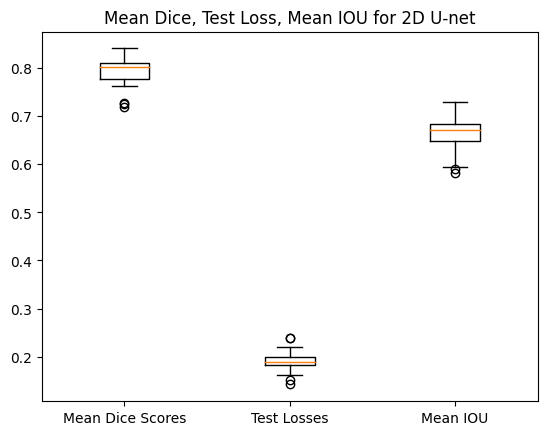

In [33]:
test_losses_numpy = [tensor.numpy() for tensor in test_losses]

plt.boxplot([mean_dice_scores, test_losses_numpy,mean_iou_test], labels=['Mean Dice Scores', 'Test Losses','Mean IOU'])
plt.title("Mean Dice, Test Loss, Mean IOU for 2D U-net")
# plt.boxplot(mean_dice_scores)
# plt.boxplot(test_losses_numpy)

print(test_losses_numpy)
print(mean_iou_test)
print(mean_iou_train)

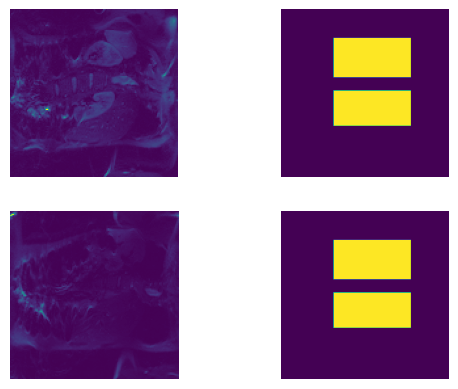

In [21]:
# Visualize some of the dataset
img_number = 5
slice = 9

image = X_train[slice]
mask = y_train[slice]

plt.subplot(2,2,1)
plt.imshow(image)
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(mask)
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(X_train[slice-5])
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(y_train[slice-5])
plt.axis("off")

plt.show()